In [8]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [237]:
# Set-up DataFrame for NLP
subreddits = pd.read_csv('../data/subreddits_clean.csv')

In [238]:
#Set-up X- and y-variables
# NOTE: cvec needs a vector(Series), not a matrix(DataFrame)
X = subreddits['submission_text']
y = subreddits['subreddit']

In [239]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=86)

In [12]:
'''
# To streamline process of stop word identification a random subset of the data, more manageable in size, is introduced here
a = list(np.sort(np.random.choice(list(subreddits.index), size=20000)))
subreddits_a = subreddits.loc[a,['submission_text','subreddit']]

Xa = subreddits_a['submission_text']
ya = subreddits_a['subreddit']

# Split the data into the training and testing sets.
Xa_train, Xa_test, ya_train, ya_test = train_test_split(Xa,
                                                    ya,
                                                    stratify=ya,
                                                    random_state=86)
'''

"\n# To streamline process of stop word identification a random subset of the data, more manageable in size, is introduced here\na = list(np.sort(np.random.choice(list(subreddits.index), size=20000)))\nsubreddits_a = subreddits.loc[a,['submission_text','subreddit']]\n\nXa = subreddits_a['submission_text']\nya = subreddits_a['subreddit']\n\n# Split the data into the training and testing sets.\nXa_train, Xa_test, ya_train, ya_test = train_test_split(Xa,\n                                                    ya,\n                                                    stratify=ya,\n                                                    random_state=86)\n"

## Model Preparation

##### Establish a baseline accuracy (predicting the plurality class)
***r/depression: 0***<br>
***r/suicide_watch: 1***


In [283]:
# The Null Model is about 50/50
print(f'{round(y_train.value_counts(normalize=True),3)}')

1    0.507
0    0.493
Name: subreddit, dtype: float64


In [291]:
# No. of documents in the corpora
print(f'No. of documents in train corpus: {len(X_train):,d}')
print(f'No. of documents in validation corpus: {len(X_test):,d}')

No. of documents in train corpus: 125,100
No. of documents in validation corpus: 41,701


### Vectorize: CountVectorizer v. TF-IDF

##### Estimator: Multinomial Naive Bayes

In [244]:
# Pipeline 1 Set-Up: cvec

# Stage 1. CountVectorizer (transformer)
# Stage 2. Multinomial Naive Bayes (estimator)
pipe_cvec = Pipeline([
    ('cvec', CountVectorizer(max_features=5000,
                             stop_words = 'english',
                             #stop_words = stop_words4,
                             ngram_range=(1,2),
                             binary=True,
                             max_df=1.0,)),
    ('nb', MultinomialNB())
])

# Pipeline 2 Set-Up: tvec
# Stage 1. TF-IDF (transformer)
# Stage 2. Multinomial Naive Bayes (estimator)
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer(max_features=5000,
                             sublinear_tf=True,
                             stop_words = 'english',
                             #stop_words = stop_words4,
                             ngram_range=(1,2),
                             binary=True,
                             max_df=1.0)),
    ('nb', MultinomialNB())
])

# Estimate Multinomial Naive Bayes performance, with each vectorizer, on unseen data
cvec_cv_score = cross_val_score(pipe_cvec, X_train, y_train, cv=5, n_jobs=-2, verbose=1).mean() 
tvec_cv_score = cross_val_score(pipe_tvec, X_train, y_train, cv=5, n_jobs=-2, verbose=1).mean()

# Display cross-val scores for easy comparison
print(f'Cross-Val Scores:\n\tCount-V = {round(cvec_cv_score*100,3)}%\n\tTF-IDF  = {round(tvec_cv_score*100,3)}%')

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   5 | elapsed:   33.7s remaining:   50.5s
[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:   35.1s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   5 | elapsed:   35.5s remaining:   53.3s


Cross-Val Scores:
	Count-V = 72.539%
	TF-IDF  = 72.245%


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:   36.8s finished


###### RUN ONLY FOR SCORE:

In [245]:
# Fit each pipeline with default parameters
pipe_cvec.fit(X_train, y_train)
pipe_tvec.fit(X_train, y_train)

# Training scores
cvec_train_score = pipe_cvec.score(X_train, y_train)
tvec_train_score = pipe_tvec.score(X_train, y_train)

# Test scores
cvec_test_score = pipe_cvec.score(X_test, y_test)
tvec_test_score = pipe_tvec.score(X_test, y_test)

# Display scores for easy comparison of Vectorizors
print(f'Training Scores:\n\tCount-V = {round(cvec_train_score*100,3)}%\n\tTF-IDF  = {round(tvec_train_score*100,3)}%')
print(f'Test Scores:\n\tCount-V = {round(cvec_test_score*100,3)}%\n\tTF-IDF  = {round(tvec_test_score*100,3)}%')

Training Scores:
	Count-V = 73.038%
	TF-IDF  = 72.927%
Test Scores:
	Count-V = 72.862%
	TF-IDF  = 72.178%


In [294]:
# Notice the No. of words from each subreddit!
print(f'WORD COUNT:\n\tSuicide Watch data: {sum(list(suicide_dict.values())):,d}\n\tDepression data:    {sum(list(depression_dict.values())):,d}')

WORD COUNT:
	Suicide Watch data: 2,623,490
	Depression data:    2,668,373


In [246]:
## Explore tokenized features: Visualize

# Instantiate CVEC Transformer
cvec = CountVectorizer(max_features=5000,
                             stop_words = 'english',
                             ngram_range=(1,2),
                             binary=True,
                             max_df=1.0)

# Transform the train corpus to obtain SciPy sparse matrices
X_train_cvec = cvec_trans.fit_transform(Xa_train)

# Convert train-data to Pandas DataFrame for easy visualization
X_train_cvec_df = pd.DataFrame(X_train_cvec.todense(), 
                              columns=cvec_trans.get_feature_names())

# Verify dimensions and dtype of vectorized object
print(X_train_cvec.shape, type(X_train_cvec))

(125100, 5000) <class 'scipy.sparse.csr.csr_matrix'>


##### Quantify tokenized difference in subreddits

In [ ]:
# Make a DataFrame to ID top words in each of the subreddits
sub = pd.DataFrame(y_train).reset_index()
words_and_subreddits = pd.concat( [X_train_cvec_df, sub],axis=1)
words_and_subreddits.drop(columns='index',inplace=True)

In [ ]:
suicide_dict = 
    words_and_subreddits[words_and_subreddits['subreddit']==1].sum().to_dict();
    
depression_dict = 
    words_and_subreddits[words_and_subreddits['subreddit']==0].sum().to_dict();

difference_dict = 
    {key: val_s-depression_dict[key] for key, val_s in suicide_dict.items() if key in depression_dict.keys()}
    
difference_df = 
    pd.DataFrame.from_dict(difference_dict, orient='index').drop(['subreddit'])
    
difference_df.sort_values(by=0, ascending=False).tail(20)

In [302]:
difference_df.sort_values(by=0, ascending=False).tail(20)

,0
hard,-1864
lot,-1893
feels,-2014
bed,-2022
day,-2044
felt,-2051
started,-2178
sad,-2230
happy,-2390
work,-2392


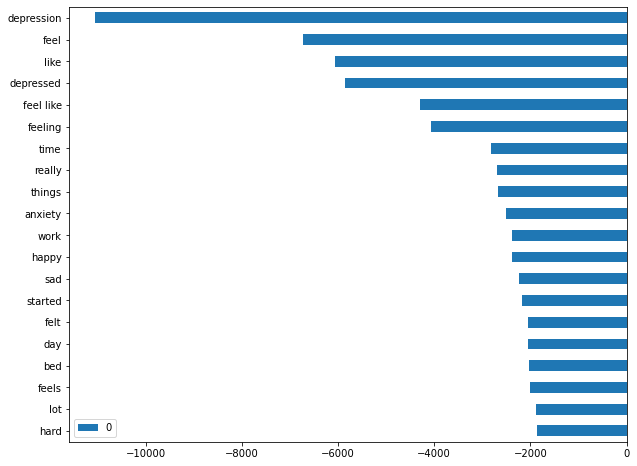

In [300]:
difference_df.sort_values(by=0, ascending=False).tail(20).plot(kind='barh',figsize=(10,8));

In [347]:
difference_df.sort_values(by=0, ascending=False)

,0
die,8213
kill,7960
suicide,7308
end,4524
want,4429
...,...
feel like,-4300
depressed,-5861
like,-6066
feel,-6736


In [379]:
%pwd

'C:\\Users\\bgrif\\Desktop\\dsi\\projects\\3project-Reddit-NLP-Classifier\\code'

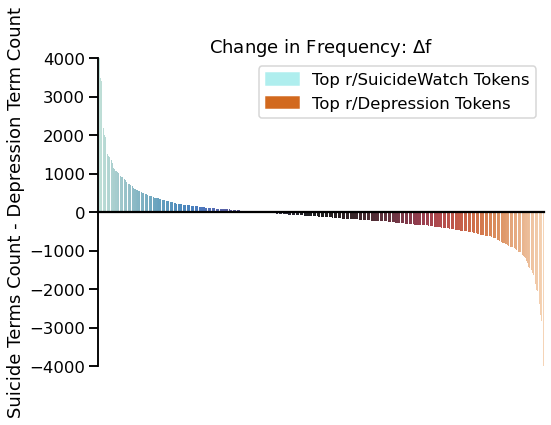

In [392]:
import matplotlib.patches as mpatches

sns.set_style()
sns.set_context('talk')
# Set up the matplotlib figure
plt.figure(figsize=(8, 6))
sns.barplot(x= difference_df.index,y=difference_df[0].sort_values(ascending=False), palette='icefire')

plt.axhline(y=0, color="k", clip_on=False)
plt.ylabel("Suicide Terms Count - Depression Term Count")
plt.xticks([])
plt.ylim(-4000,4000)

# Finalize the plot
sns.despine(bottom=True)
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)

label_patch = [mpatches.Patch(color='PaleTurquoise', label='Top r/SuicideWatch Tokens'),
               mpatches.Patch(color='Chocolate', label='Top r/Depression Tokens',size)]

# https://stackoverflow.com/questions/13338550/typing-greek-letters-etc-in-python-plots
plt.title(r'Change in Frequency: $\Delta$f')
plt.legend(handles=label_patch );
plt.savefig('../images/frequency_difference.png',dpi=200, bbox_inches='tight');

In [353]:
setp(line)

NameError: name 'setp' is not defined

AttributeError: module 'seaborn' has no attribute 'histplot'

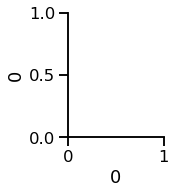

In [345]:
import seaborn as sns
g = sns.PairGrid(difference_df)
g.map_upper(sns.distplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

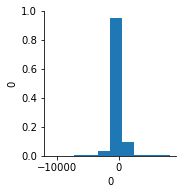

In [309]:
sns.pairplot(difference_df)

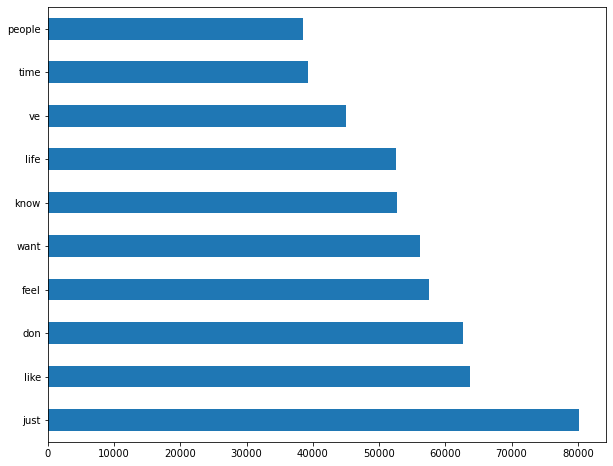

In [297]:
# plot top occuring words
X_train_cvec_df.sum().sort_values(ascending=False).head(10).plot(kind='barh',figsize=(10,8));
#plt.axvline(x=X_train_cvec_df.sum().sort_values().quantile(q=0.98),c='r');

### Fig. 01  
***Notice the 97th quantile (red line) is right on the boundary of introducing 'want to', the 2-gram with the highest document frequency. I like this to be my first guess for a cut-off max_df because n-grams are one of the few ways that this model will account for the contextual meaning typically present in language. There are uninteresting tokens, both more and less frequent, but tokens more frequently occurring in the data will be designated as Stop-Words for initial model tuning.***

In [272]:
print(X_train_cvec_df.shape)
X_train_cvec_df.sum().sort_values(ascending=False)[:10]

(125100, 5000)


just      80216
like      63716
don       62682
feel      57464
want      56185
know      52773
life      52549
ve        44935
time      39230
people    38542
dtype: int64

In [273]:
# Notice the 97th quantile is right on the boundary of introducing the most frequent 2-gram.
print(X_train_df.sum().sort_values().quantile(q=0.964))
X_train_df.sum().sort_values()[962:965]

NameError: name 'X_train_df' is not defined

In [274]:
# % of documents in X_train with 2-gram 'want to' 
round(X_train_df.sum().sort_values()[963:964]/X_train.shape[0],3)

NameError: name 'X_train_df' is not defined

In [ ]:
# Inspect tokens in corpus
cvec.get_feature_names()[800:900];
len(cvec.vocabulary_)
cvec.stop_words_;
cvec.vocabulary_;
cvec.get_feature_names();

In [276]:
# For my stop words I took the 10,000 most common words and found that 255 of them were in the CountVectorizer's list of 318 'english' stop-words.
# I then went through those 255 and removed theh ones that did not seem approrpriate to keep. That list is my stop_words_removed.
stops_cvec = list(CountVectorizer(stop_words = 'english').get_stop_words())
print(f'No. of Stop Words in C-Vec: {len(stops_cvec)}')

tops = X_train_cvec_df.sum().sort_values(ascending=False)[:5000].index.tolist()
print(f'No. of Stop Words chosen: {len(tops)}')

No. of Stop Words in C-Vec: 318
No. of Stop Words chosen: 5000


In [277]:
X_train_cvec_df[X_train_cvec_df.isnull()].sum()

000           0.0
10            0.0
10 minutes    0.0
10 years      0.0
100           0.0
             ... 
youtube       0.0
zero          0.0
zoloft        0.0
zombie        0.0
zone          0.0
Length: 5000, dtype: float64

In [90]:
# Look at the top 500 tokens in each subreddit
suicide_top500 = list(words_and_subreddits[words_and_subreddits['subreddit']==1].sum().sort_values(ascending=False)[:100].index)
depression_top500 = list(words_and_subreddits[words_and_subreddits['subreddit']==0].sum().sort_values(ascending=False)[:100].index)

both = []
suicide_only = []
depression_only =[]
for token in suicide_top500:
    if token in depression_top500:
        both.append(token)
    else:
        suicide_only.append(token)
        
for token in depression_top500:
    if token not in suicide_top500:
        depression_only.append(token)
        
print(f' Both: {len(both)}, Suicide Only: {len(suicide_only)}, Depression Only: {len(depression_only)}')

 Both: 88, Suicide Only: 12, Depression Only: 12


In [259]:
difference_df.sort_values(by=0, ascending=False).iloc[261:486];

In [227]:
difference_df.sort_values(by=0, ascending=False).iloc[350:400].index

Index(['thought', 'miserable', 'soul', 'year old', 'days ago', 'know want',
       'quarantine', 'pointless', 'know people', 'hoping', 'possible',
       'wanted', '25', 'getting better', 'given', 'feel guilty', 'pressure',
       'second', 'doctors', 'known', 'treat', 'reach', '22', 'order', 'simply',
       'caring', 'gets', 'writing', 'maybe just', 'afford', 'age', 'asleep',
       'really just', 'broken', 'dumb', '12', 'mistakes', 'right', 'hurts',
       'water', 'nearly', 'oh', 'broke', 'want know', 'doubt', 'didn want',
       'older', 'breaking', 'loving', 'answer'],
      dtype='object')

In [278]:
# Look at the second half of top 1000 tokens in each subreddit (aka [500:1000])
suicide_500_1000 = 
    list(words_and_subreddits[words_and_subreddits['subreddit']==1].sum()\
         .sort_values(ascending=False)[500:1000].index)
    
depression_500_1000 = 
    list(words_and_subreddits[words_and_subreddits['subreddit']==0].sum()\
         .sort_values(ascending=False)[500:1000].index)

both = []
suicide_only = []
depression_only =[]
for token in suicide_500_1000:
    if token in depression_500_1000:
        both.append(token)
    else:
        suicide_only.append(token)
        
for token in depression_500_1000:
    if token not in suicide_500_1000:
        depression_only.append(token)
        
print(f' Both: {len(both)}, Suicide Only: {len(suicide_only)}, Depression Only: {len(depression_only)}')

 Both: 439, Suicide Only: 61, Depression Only: 61


In [69]:
# After investigating stop words it became apparant that the best scores were with 
# CountVectorizers standard set of 'english' stop words
STOPS = list(CountVectorizer(stop_words = 'english').get_stop_words())
print(f'No. of Stop Words in C-Vec: {len(stops_cvec)}')

print(f'No. of top 500 Words in both subreddits: {len(both)}')
stop_words_in_both = []
stop_words_in_both4 = []
subject_stop_words = []
for word in both:
    if word in STOPS:
        stop_words_in_both.append(word)
    else:
        subject_stop_words.append(word)
print(f'No. of top 500 Stop Words in both subreddits: {len(stop_words_in_both)}')
print(f'No. of top 500 subject specific Stop Words appearing in both subreddits: {len(subject_stop_words)}')

No. of Stop Words in C-Vec: 318
No. of top 500 Words in both subreddits: 439
No. of top 500 Stop Words in both subreddits: 30
No. of top 500 subject specific Stop Words appearing in both subreddits: 409


### NOTE:

No. of Stop Words in CountVectorizer: 318
No. of top 500 Words in both subreddits: 460
No. of top 500 Stop Words in both subreddits: 153
No. of top 500 subject specific Stop Words appearing in both subreddits: 307

In [ ]:
text_and_subredditwords = []
maybes =[]
for word in tops:
    if word in stops:
        my_stop_words.append(word)
    else:
        maybes.append(word)
len(my_stop_words)

In [ ]:
%store -r my_stop_words
len(my_stop_words)